In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras import Input, Model, layers, models


import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import functions_ai

In [2]:
custom_preprocessing = functions_ai.custom_preprocessing

In [3]:
import numpy as np
import random
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [4]:

#set the paths/directories
path = pathlib.Path('covid xray')
train_dir = os.path.join(path, 'train') 
validation_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

test_covid_dir = os.path.join(test_dir, 'COVID')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

#print(train_dir)

In [5]:
custom_preprocessing = functions_ai.custom_preprocessing
BATCH_SIZE = 32
IMG_HEIGHT = IMG_WIDTH = 128 #heb dit veranderd naar 128
EPOCHS = 30
dropout_rate = 0.5

In [6]:
train_data_gen = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                             label_mode='binary',
                                                             batch_size=BATCH_SIZE,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH))
val_data_gen = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                           label_mode='binary',
                                                           batch_size=BATCH_SIZE,
                                                           image_size=(IMG_HEIGHT, IMG_WIDTH))
test_data_gen = tf.keras.utils.image_dataset_from_directory(test_dir, 
                                                            label_mode = 'binary', 
                                                            batch_size = BATCH_SIZE,
                                                            image_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                            #shuffle = False) #set shuffle = False when running/computing the covariance matrix
                                                            shuffle = True) #set shuffle = True for visual evaluation 

                                                             #when changed remember to run the 3 blocks code below

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [7]:
def preprocess_image(transform):
    
    def _preprocess(image, label):
        return transform(image), label
        
    return _preprocess

In [8]:
rescale = Rescaling(1 / 255)

In [9]:
train_data_preproc = train_data_gen.map(preprocess_image(rescale))
val_data_preproc = val_data_gen.map(preprocess_image(rescale))
test_data_preproc = test_data_gen.map(preprocess_image(rescale))

flip =  RandomFlip("horizontal")
rotate = RandomRotation(factor=(-1/24, 1/24))  # of korter: factor=1/12
translate = RandomTranslation(height_factor=0.15, width_factor=0.15)
zoom = RandomZoom(0.1)
augment = Sequential((flip, rotate, translate, zoom))

train_data_preproc = train_data_preproc.map(lambda x, y: (augment(x, training=True), y))


In [10]:
train_data_preproc = train_data_preproc.cache()
val_data_preproc = val_data_preproc.cache()
test_data_preproc = test_data_preproc.cache()

In [11]:
flip =  RandomFlip("horizontal")
rotate = RandomRotation(factor=(-1/24, 1/24))  # of korter: factor=1/12
translate = RandomTranslation(height_factor=0.15, width_factor=0.15)
zoom = RandomZoom(0.1)
augment = Sequential((flip, rotate, translate, zoom))


In [12]:
# Input
inputs = tf.keras.Input(shape=(128, 128, 3))
x = inputs

# Get base model
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(128, 128, 3)
)
base_model.trainable = False

# Get intermediate layer from base model
last_conv_layer_name = 'conv5_block3_out'
last_conv_layer = base_model.get_layer(last_conv_layer_name)

# Apply base_model and capture output of last conv layer
x = base_model(x)

# Save for Grad-CAM
gradcam_output = x

# Continue with custom classifier
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Final model — note: x is already connected to gradcam_output
model = Model(inputs=inputs, outputs=outputs)

In [13]:
model.summary()  # Optioneel: modelstructuur bekijken

# Voorverwerking zoals in task 1
img_size = (128, 128)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'covid xray/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Klassenlabels ophalen
class_indices = test_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

print("Model en testset zijn geladen.")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,408,321 (154.15 MB)

 Trainable params: 16,843,521 (64.25 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Found 200 images belonging to 2 classes.
Model en testset zijn geladen.


In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [15]:
combined_data_preproc = train_data_preproc.concatenate(val_data_preproc).shuffle(buffer_size=10000,  # possibly larger than dataset size.
                                                                            reshuffle_each_iteration=True)
early_stop= tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 5, restore_best_weights=True)
history= model.fit(
        combined_data_preproc, 
        epochs=30,
        batch_size= 32,
        callbacks=[early_stop],
        verbose=1)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 740ms/step - accuracy: 0.7111 - loss: 3.2827
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 627ms/step - accuracy: 0.8625 - loss: 0.3777
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 769ms/step - accuracy: 0.9174 - loss: 0.2030
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 769ms/step - accuracy: 0.9279 - loss: 0.1708
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 755ms/step - accuracy: 0.9629 - loss: 0.1000
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 741ms/step - accuracy: 0.9596 - loss: 0.1108
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 738ms/step - accuracy: 0.9830 - loss: 0.0470
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 750ms/step - accuracy: 0.9827 - loss: 0.0501
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 753ms/step - accuracy: 0.9912 - loss: 0.0249
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 746ms/step - accuracy: 0.9931 - loss: 0.0209
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 754ms/step - accuracy: 0.9909 - loss: 0.0270
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47

In [16]:
from tensorflow.keras.models import load_model

model.save("modeltask4.keras")
model_task4 = tf.keras.models.load_model('modeltask4.keras')

# Grad-CAM

## Configurable parameters

Sample image path: covid xray/test\NORMAL\Normal-2031.png


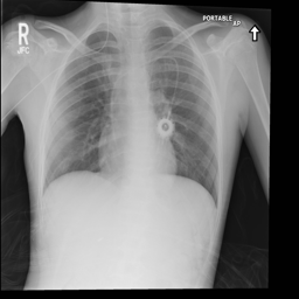

In [36]:
import keras
from IPython.display import Image, display
import matplotlib as mpl
img_size = (128, 128)
preprocess_input = keras.applications.xception.preprocess_input

last_conv_layer_name = "conv5_block3_3_conv" 

# The local path to our target image
test_image_dir = 'covid xray/test'
for root, dirs, files in os.walk(test_image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            break
    if 'img_path' in locals():
        break

print(f"Sample image path: {img_path}")


display(Image(img_path))

## The Grad-CAM algorithm

In [37]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_output_model, pred_index=None):
    with tf.GradientTape() as tape:
        # Run forward pass
        conv_output, preds = last_conv_layer_output_model(img_array, training = False)
        #training = False, You need to disable augmentations during Grad-CAM generation by forcing training=False when calling the model
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Get gradients of class wrt last conv layer
    grads = tape.gradient(class_channel, conv_output)

    #average pooling: gives weight per channel 
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    #This does a weighted sum across channels, using the pooled gradients as weights
    
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    #this normalizes the heatmap
    
    return heatmap.numpy()

In [38]:
# Grad-CAM model that gives both last conv layer and prediction
grad_model = tf.keras.models.Model(
    [model.inputs],
    [gradcam_output, model.output]
)

## Test Drive

In [39]:
last_conv_layer = 'conv5_block3_3_conv'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted class: NORMAL


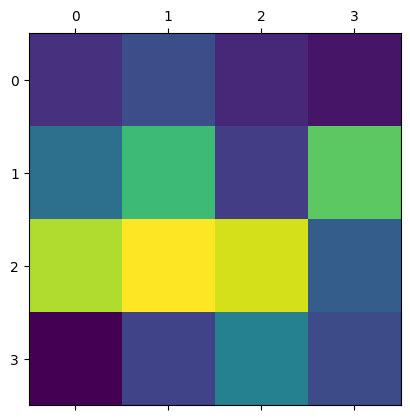

In [40]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
grad_model.layers[-1].activation = None
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

#Note that this tutorial assumes a model that outputs a value for each class. If your model outputs only a scalar, as is
#usually the case with binary classification, you must account for it in the implementation.

predicted_class_index = int(preds[0].item() > 0.5)  # Threshold at 0.5 for binary
predicted_class_label = inv_class_indices[predicted_class_index]
print("Predicted class:", predicted_class_label)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, grad_model)

# Display heatmap
plt.matshow(heatmap)
plt.show()

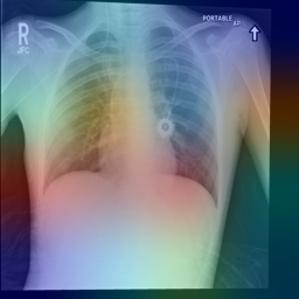

In [41]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img # Overlay the heatmap on the original image, by adding to its values rescaled by 0.4
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# Explaining the decision with Grad-CAM:

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step

Aantal voorbeelden per groep:
True Positives: 94
True Negatives: 87
False Positives: 13
False Negatives: 6

Toon Grad-CAMs uit elke groep:

True Positives
Bestand: Normal-2071.png | Voorspeld: NORMAL | Waarheid: NORMAL


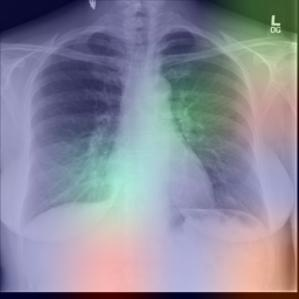

Bestand: Normal-2036.png | Voorspeld: NORMAL | Waarheid: NORMAL


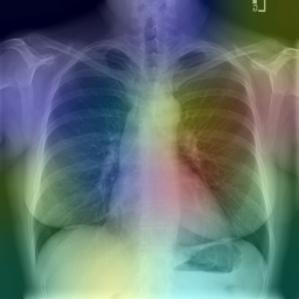

Bestand: Normal-2074.png | Voorspeld: NORMAL | Waarheid: NORMAL


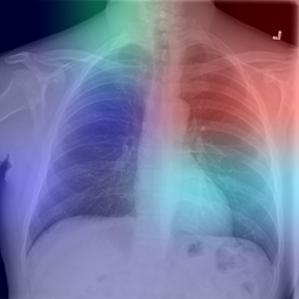

Bestand: Normal-2002.png | Voorspeld: NORMAL | Waarheid: NORMAL


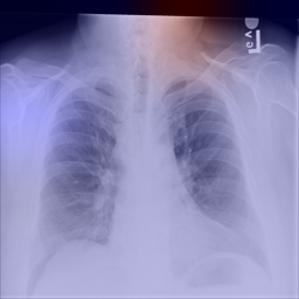

Bestand: Normal-2092.png | Voorspeld: NORMAL | Waarheid: NORMAL


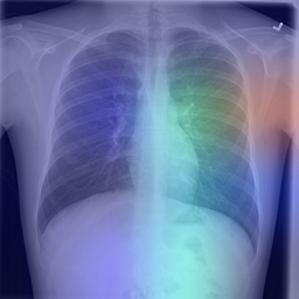


True Negatives
Bestand: COVID-2015.png | Voorspeld: COVID | Waarheid: COVID


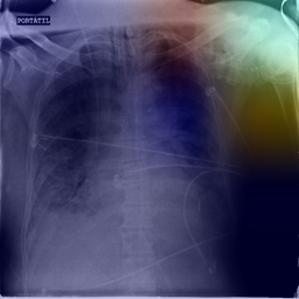

Bestand: COVID-2081.png | Voorspeld: COVID | Waarheid: COVID


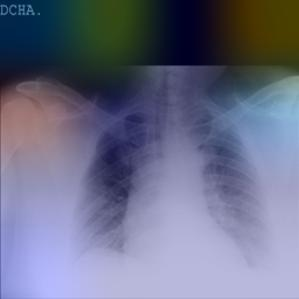

Bestand: COVID-2036.png | Voorspeld: COVID | Waarheid: COVID


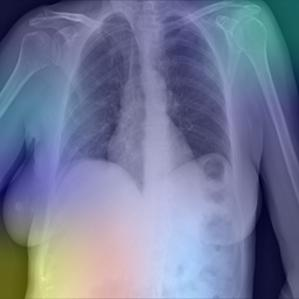

Bestand: COVID-2095.png | Voorspeld: COVID | Waarheid: COVID


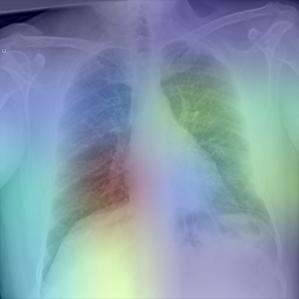

Bestand: COVID-2051.png | Voorspeld: COVID | Waarheid: COVID


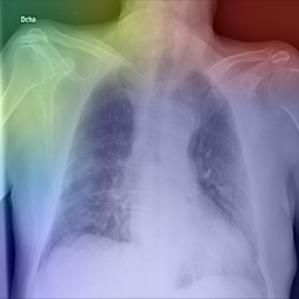


False Positives
Bestand: COVID-2038.png | Voorspeld: NORMAL | Waarheid: COVID


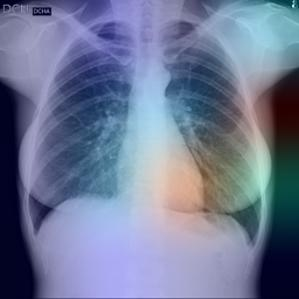

Bestand: COVID-2043.png | Voorspeld: NORMAL | Waarheid: COVID


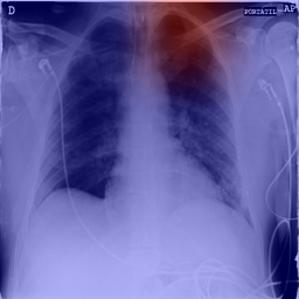

Bestand: COVID-2049.png | Voorspeld: NORMAL | Waarheid: COVID


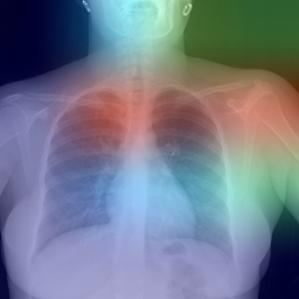

Bestand: COVID-2041.png | Voorspeld: NORMAL | Waarheid: COVID


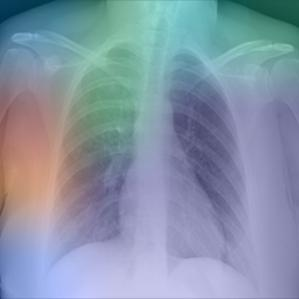

Bestand: COVID-2054.png | Voorspeld: NORMAL | Waarheid: COVID


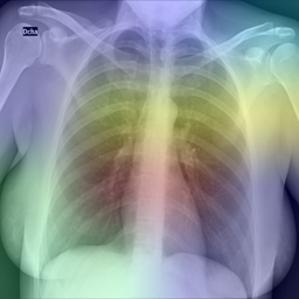


False Negatives
Bestand: Normal-2022.png | Voorspeld: COVID | Waarheid: NORMAL


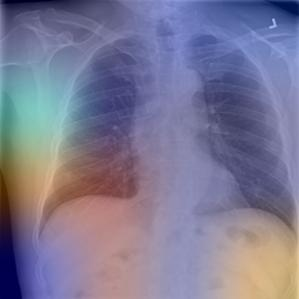

Bestand: Normal-2031.png | Voorspeld: COVID | Waarheid: NORMAL


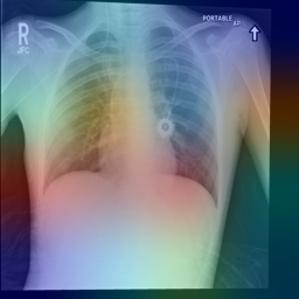

Bestand: Normal-2028.png | Voorspeld: COVID | Waarheid: NORMAL


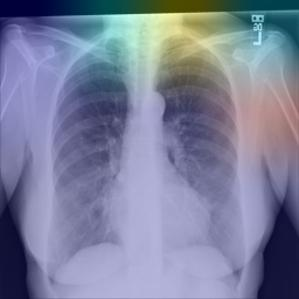

Bestand: Normal-2096.png | Voorspeld: COVID | Waarheid: NORMAL


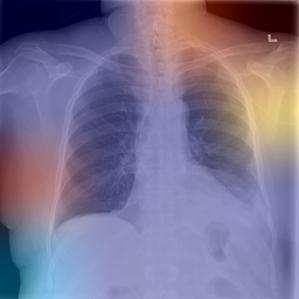

Bestand: Normal-2097.png | Voorspeld: COVID | Waarheid: NORMAL


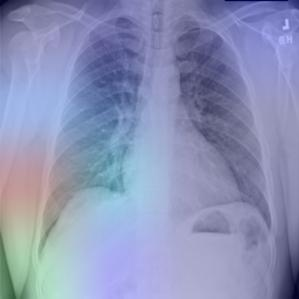

In [42]:
import random
from sklearn.metrics import confusion_matrix

# 1. predict full testset
test_generator.reset()
pred_probs = model.predict(test_generator, verbose=1)
preds = (pred_probs > 0.5).astype(int).flatten()
true_labels = test_generator.classes

# 2. generate paths for images
file_paths = [os.path.join(test_generator.directory, path) for path in test_generator.filenames]

# 3. sort images
TP, TN, FP, FN = [], [], [], []

for i, (pred, true) in enumerate(zip(preds, true_labels)):
    sample = (file_paths[i], pred, true)  # (pad, voorspelling, waarheid)
    if pred == 1 and true == 1:
        TP.append(sample)
    elif pred == 0 and true == 0:
        TN.append(sample)
    elif pred == 1 and true == 0:
        FP.append(sample)
    elif pred == 0 and true == 1:
        FN.append(sample)

groups = {'True Positives': TP, 'True Negatives': TN, 'False Positives': FP, 'False Negatives': FN}

print("\nAantal voorbeelden per groep:")
for name, group in groups.items():
    print(f"{name}: {len(group)}")

# 4. show Grad-CAMs/group
print("\nToon Grad-CAMs uit elke groep:")

for name, group in groups.items():
    print(f"\n{name}")
    samples = random.sample(group, min(5, len(group)))  # max. 5 ewamples per group
    for img_path, pred, true in samples:
        print(f"Bestand: {img_path.split(os.sep)[-1]} | Voorspeld: {inv_class_indices[pred]} | Waarheid: {inv_class_indices[true]}")
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, model, grad_model)
        save_and_display_gradcam(img_path, heatmap)
